**Model molecular SMILES data with Amazon Neptune and RDKit**

   Modeling chemical structures can be a complex and tedious process, even with the help of modern programs and technology. The ability to explore chemical structures at the most fundamental level of atoms and the bonds that connect them is an essential process in [drug discovery, pharmaceutical research](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.0c00947), and [chemical engineering](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8130509/). By infusing chemical research with technology, researchers can expedite outcome timelines, identify hidden relationships, and overall simplify a traditionally complex process. 

**Solution Overview**

In order to integrate technology into the analysis of chemical structures, molecules themselves must first be represented in a machine-readable format, such as [SMILES (simplified molecular-input line-entry system)](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). SMILES format strings are the industry standard in representing molecular structures. The SMILES format enables the relationships between atoms in a molecular structure to be conveyed as a machine processable string. The SMILES format is not all encompassing, leaving out details such as certain polarities and bond properties. However, SMILES does enable powerful analysis at scale of different structures. 

Using Amazon Neptune and open-source chemical-informaics software package [RDKit](https://www.rdkit.org/), SMILES format data can be ingested, processed, and converted into nodes and edges in a property graph. Modeling molecular structures in a graph database allows for powerful custom visualization and manipulation at the scale demanded by pharmaceutical applications. Utilizing a graph database such as Neptune allows users to compare millions of molecules with millions of associated interactions. Additionally, the fully managed and serverless infrastructure allows experts with backgrounds in biology and chemistry to focus primarily on the research outcomes of their graph data, avoiding the undifferentiated heavy lifting of managing a complex graph database infrastructure.

This walkthrough follows the process of converting a singular SMILES string, caffeine, to graph data in Neptune. However, the process will work for any SMILES format string you would like to use. We’re sourcing the string for caffeine from the [National Library of Medicine](https://pubchem.ncbi.nlm.nih.gov/compound/2519#section=InChI), which maintains a public dataset of many chemical structures [CN1C=NC2=C1C(=O)N(C(=O)N2C)C].


We also use the open-source cheminformatics package [RDKit](https://github.com/rdkit/rdkit), Python-based data science package [Pandas](https://pandas.pydata.org/), and [AWS SDK for pandas (awswrangler)](https://aws-sdk-pandas.readthedocs.io/en/stable/). RDKit has a strong community and a great number of chem-informatics utilities; we’ll only be exploring a small portion for this post. Pandas is an open-source Python-based data science toolkit with large community support. AWS SDK for pandas provides a large librarty to help AWS services interact with the pandas library.

**Package Setup**

The first step in modeling a chemical structure as graph data is importing the required packages. Here we will be using RDKit, Pandas, and awswrangler

In [26]:
%pip install rdkit

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [27]:
%pip install awswrangler

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [43]:
from rdkit import Chem
import pandas as pd
import awswrangler as wr

**Graph Data Model**

There are a few different options for graph query languages and their associated data models when working with Neptune; in this case we’re using Apache TinkerPop’s Gremlin. We are opting for Gremlin here due to its intuitive nature and easy to learn syntax. The below cell is defining a dictionary object for both the nodes and edges of our graph. Within each dictionary object is a set of properties we will gather from our caffeine molecule in the next section.

In [44]:
nodes_dict = {'~id':[],
                '~label':[],
                'idx':[],
                'atomicNumber':[],
                'isAromatic': []
               }
               
edges_dict = {'~id':[],
                '~label':[],
                '~from':[],
                '~to':[],
               }

**RDKit Processing**

This section is where the chemical computing magic happens. We use the RDKit package installed earlier in the graph notebook to decompose our chemical structure into lists of nodes (atoms) and edges (bonds).

First, we want to declare our SMILES string for the caffeine molecule as a variable.

In [30]:
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

Next, to obtain a molecule-type object from the RDKit package, we need to use the below call to the "Chem" library from RDKit imported earlier.

In [31]:
mol = Chem.MolFromSmiles(caffeine_smiles)

Let’s see a visual of our work so far, run the following cell to output a 2D picture of our molecule below.

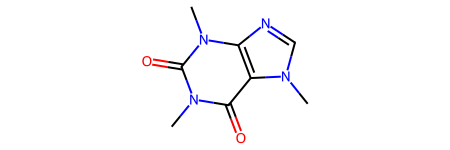

In [45]:
mol

To recap what we just did, first we declared our SMILES string for caffeine as the variable caffeine_smiles. Next, we used the Chem.MolFromSmiles function from RDKit to turn the SMILES into a Mol type object defined by RDKit. Finally, we returned the Mol type object which resulted in a 2D image of the molecular structure for caffeine that we are working with.

Now we need to iterate through each atom and bond within the mol object outputted from RDKit. While iterating through each atom and bond, we use the graph data model we declared earlier, storing properties of each inside the data model. Feel free to dive deeper into the mol.GetAtoms() and mol.GetBonds() function calls on your own - we are only exploring a small subet of their functionality.

In [33]:
for atom in mol.GetAtoms():
    nodes_dict['~id'].append('Node-'+ caffeine_smiles + str(atom.GetIdx()))
    nodes_dict['~label'].append(atom.GetSymbol())
    nodes_dict['idx'].append(atom.GetIdx())
    nodes_dict['atomicNumber'].append(atom.GetAtomicNum())
    nodes_dict['isAromatic'].append(atom.GetIsAromatic())

for bond in mol.GetBonds():
    edges_dict['~id'].append('edge-'+ caffeine_smiles + str(bond.GetBeginAtomIdx()) + str(bond.GetEndAtomIdx()))
    edges_dict['~label'].append(str(bond.GetBondType()))
    edges_dict['~from'].append('Node-' + caffeine_smiles + str(bond.GetBeginAtomIdx()))
    edges_dict['~to'].append('Node-' + caffeine_smiles + str(bond.GetEndAtomIdx()))

Several different RDKit functions are in this portion of code, so let’s break it down piece by piece: 

•	For the ~id field of both nodes and edges, we combine the data type Node or Edge, the SMILES string itself, and the unique index for the atom

•	For the ~label field, we use the chemical symbol for nodes, and the bond type for the edges

•	The fields ~from and ~to for the edges (bonds) are constructed by combining the prefix Node- with the SMILES string, and the respective beginning and ending atoms that the bond connects

•	The additional fields for the nodes (atoms) in the graph model are the atom’s unique ID within the molecule, its atomic number, and if it is aromatic or not

Note that you can extract several atomic properties for a given SMILES string in RDKit and add them as additional fields for a given atom or bond. We don’t list them all in this post, but you can explore additional fields for both the atoms and bonds.

Finally, we want to use pandas to transform our data-poulated dictionaries into pandas data frames

In [34]:
nodes_df = pd.DataFrame.from_dict(nodes_dict)
edges_df = pd.DataFrame.from_dict(edges_dict)

lets check the results of our work so far. Running the cells below should return data frames for both the edges and nodes of our caffeine molecule.

In [35]:
edges_df

,~id,~label,~from,~to
0,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C01,SINGLE,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C0,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C1
1,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C12,AROMATIC,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C1,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C2
2,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C23,AROMATIC,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C2,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C3
3,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C34,AROMATIC,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C3,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C4
4,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C45,AROMATIC,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C4,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C5
5,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C56,AROMATIC,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C5,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C6
6,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C67,DOUBLE,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C6,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C7
7,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C68,AROMATIC,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C6,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C8
8,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C89,AROMATIC,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C8,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C9
9,edge-CN1C=NC2=C1C(=O)N(C(=O)N2C)C910,DOUBLE,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C9,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C10


In [46]:
nodes_df

,~id,~label,idx,atomicNumber,isAromatic
0,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C0,C,0,6,False
1,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C1,N,1,7,True
2,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C2,C,2,6,True
3,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C3,N,3,7,True
4,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C4,C,4,6,True
5,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C5,C,5,6,True
6,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C6,C,6,6,True
7,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C7,O,7,8,False
8,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C8,N,8,7,True
9,Node-CN1C=NC2=C1C(=O)N(C(=O)N2C)C9,C,9,6,True


**Amazon Neptune Data Upload**

Now that we have successfully decomposed our caffeine SMILES string into individual atoms and bonds, the next step is to load our data into the Neptune database itself. This will be much simpler than loading data from an external source because our data is already inside the graph notebook environment. In order write our data to the Neptune database we will be using the AWS SDK for pandas, also known as awswrangler

First, we need to check our notebook configuration to gather the host endpoint for our cluster. Runnning the below cell will provide that information, along with a set of other important details about our Neptune database

In [47]:
%graph_notebook_config

{
  "host": "neptuneblogmolecularmodeling.cluster-ccxzwdofypk5.us-east-1.neptune.amazonaws.com",
  "port": 8182,
  "proxy_host": "",
  "proxy_port": 8182,
  "auth_mode": "DEFAULT",
  "load_from_s3_arn": "",
  "ssl": true,
  "ssl_verify": true,
  "aws_region": "us-east-1",
  "sparql": {
    "path": "sparql"
  },
  "gremlin": {
    "traversal_source": "g",
    "username": "",
    "password": "",
    "message_serializer": "graphsonv3"
  },
  "neo4j": {
    "username": "neo4j",
    "password": "password",
    "auth": true,
    "database": null
  }
}


Find the **host** field from the above output and copy & paste the string into the below cell where it says **'[INSERT YOUR HOST HERE]'**. Also, check the port number above, ensure that the port number above is the same as the second parameter in the cell below. The default port number should be 8182.

Run cell below once the host & port is properly copied from your graph configuration output above. This cell is simply using a command from the neptune section of the awswrangler library to establish a connection to your neptune instance.

In [39]:
client = wr.neptune.connect("INSERT YOUR HOST HERE", 8182, iam_enabled=False)

The next two cells use the .to_proprty_graph functions within awswrangler to insert both the node & edge data frames we creates earlier into our neptune database. Both cells should return a "True" upon success.

In [40]:
wr.neptune.to_property_graph(client, df=nodes_df)

True

In [41]:
wr.neptune.to_property_graph(client, df=edges_df)

QueryFailed: 499: {"code":"ConstraintViolationException","requestId":"a3125bf4-3c71-4a08-8fbb-1aebd0558410","detailedMessage":"Edge with id already exists: "}

After recieving a "True" from both cells you are finished with processing your SMILES molecule string and are ready to move onto visualizing your molecule as graph data. If you wish to add additional compounds to your graph database you can return to the start of the "RDKit Processing" section and simply redo the process with a differnt molecules SMILES string.

**Basic Visualization & Queries**

Now that we have processed and loaded our molecular data, lets visualize the results of our efforts so far. The below cell uses a Gremlin query to traverse outwards from nodes which are labeled as 'C' (for the element Carbon), giving us a picture of the overall structure of our molecule.

In [67]:
%%gremlin -p v,ine,outv,oute,inv,oute,inv,oute,inv,oute,inv
g.V().has('~label','C').repeat(outE().inV()).emit().times(5).path().by(valueMap(true))

You should recieve an interactive view of the 2D image RDKit produced earlier as the output of the above cell. Feel free to explore the structure and compare it to other visualizations you might be able to find of your molecule. Also, now that our molecule is persisted as graph data, you can manipulate, edit, and add additional data to your molecular structure as you see fit.

**Clean Up - WILL DELETE MOLECULE DATA**

Run the cell below to delete the data in the graph if you want to clean everything out. This iterates through the nodes_df so be sure to adjust if you have added any of your own additional molecules or edits.

In [69]:
for i in nodes_df['~id']:
    wr.neptune.execute_gremlin(client, "g.V().has('~id', '"+i+"').drop();")